# Stable Diffusion XL with Neuronx: Text to image

`🤗 Optimum` extends `🤗 Diffusers` to support inference on the second generation of Neuron devices(powering Trainium and Inferentia 2). It aims at inheriting the ease of Diffusers on Neuron.

To get started, make sure you have [configured your inf2 / trn1 instance](https://huggingface.co/docs/optimum-neuron/installation), and installed optimum:

In [2]:
!pip install "optimum[neuronx, diffusers]" matplotlib

## Compilation

To deploy SDXL models, we will also start by compiling the models. We support the export of following components in the pipeline to boost the speed:

* Text encoder
* Second text encoder
* U-Net (a three times larger UNet than the one in Stable Diffusion pipeline)
* VAE encoder
* VAE decoder

You can either compile and export a Stable Diffusion Checkpoint via CLI or `NeuronStableDiffusionXLPipeline` class. 
In this tutorial, we will export [`stabilityai/stable-diffusion-xl-base-1.0`](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) with the API.

In [1]:
from optimum.neuron import NeuronStableDiffusionXLPipeline

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
num_image_per_prompt = 1
input_shapes = {"batch_size": 1, "height": 1024, "width": 1024, "num_image_per_prompt": num_image_per_prompt}
compiler_args = {"auto_cast": "matmul", "auto_cast_type": "bf16"}

In [2]:
# Compile and save
stable_diffusion_xl = NeuronStableDiffusionXLPipeline.from_pretrained(
    model_id, export=True, device_ids=[0, 1], **compiler_args, **input_shapes
)
Load already exported artifacts
# stable_diffusion_xl = NeuronStableDiffusionXLPipeline.from_pretrained("sd_neuron_xl/", device_ids=[0, 1])

save_directory = "sd_neuron_xl/"
stable_diffusion_xl.save_pretrained(save_directory)

In [ ]:
# Push to hub
stable_diffusion_xl.push_to_hub(save_directory, repository_id="Jingya/stable-diffusion-xl-base-1.0-neuronx", use_auth_token=True)

Feel free to use the following command as well for compiling and exporting the model:

```bash
optimum-cli export neuron --model stabilityai/stable-diffusion-xl-base-1.0 \
  --task stable-diffusion-xl \
  --batch_size 1 \
  --height 1024 `# height in pixels of generated image, eg. 768, 1024` \
  --width 1024 `# width in pixels of generated image, eg. 768, 1024` \
  --num_images_per_prompt 1 `# number of images to generate per prompt, defaults to 1` \
  --auto_cast matmul `# cast only matrix multiplication operations` \
  --auto_cast_type bf16 `# cast operations from FP32 to BF16` \
  sd_neuron/
```

## Text-to-image Inference

With pre-compiled Stable Diffusion models, now generate an image with a prompt on Neuron:

In [3]:
from diffusers import DPMSolverMultistepScheduler

stable_diffusion_xl = NeuronStableDiffusionXLPipeline.from_pretrained("sd_neuron_xl/")
stable_diffusion_xl.scheduler = DPMSolverMultistepScheduler.from_config(stable_diffusion_xl.scheduler.config)

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
import numpy as np 

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 14.14 seconds.


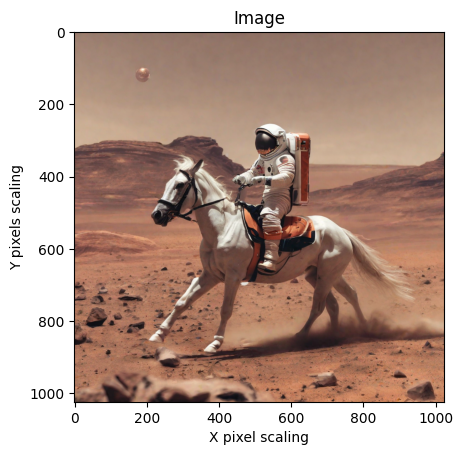

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 14.47 seconds.


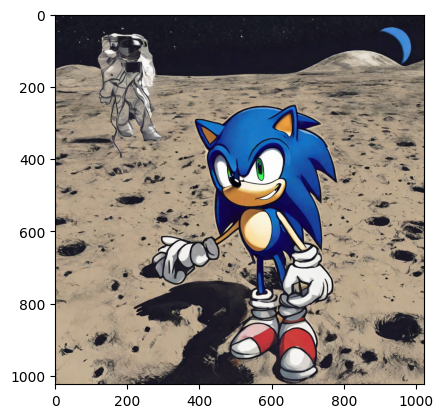

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 13.33 seconds.


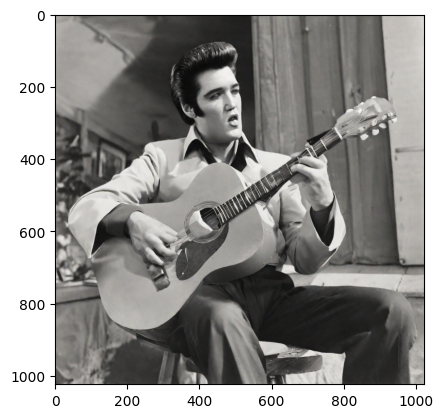

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 13.31 seconds.


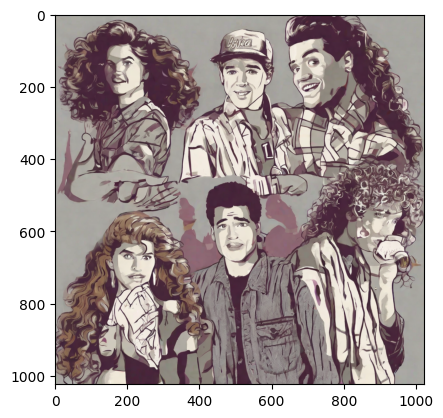

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 14.62 seconds.


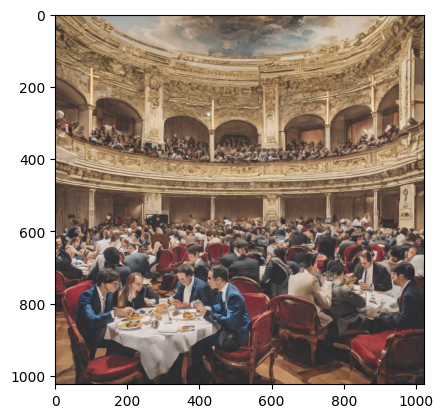

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 14.01 seconds.


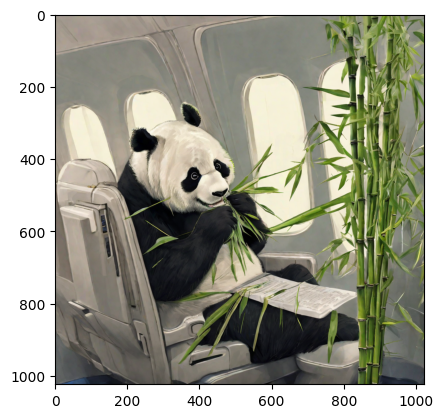

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 13.65 seconds.


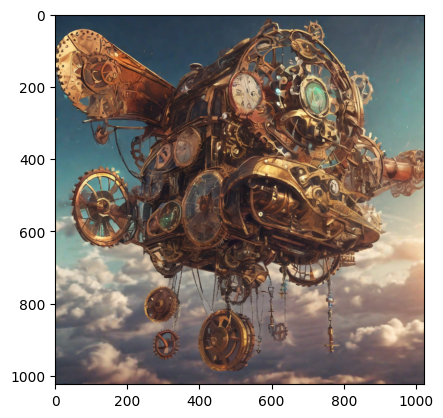

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 14.04 seconds.


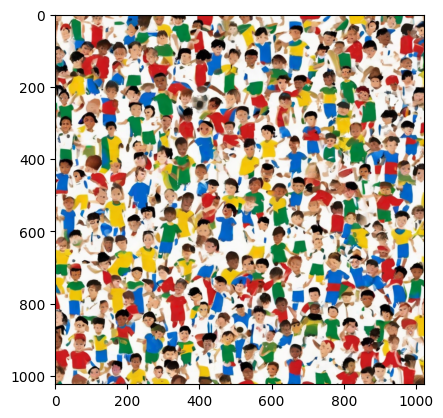

In [5]:
# Run pipeline
prompt = [
    "a photo of an astronaut riding a horse on mars",
    "sonic on the moon",
    "elvis playing guitar while eating a hotdog",
    "saved by the bell",
    "engineers eating lunch at the opera",
    "panda eating bamboo on a plane",
    "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
    "kids playing soccer at the FIFA World Cup"
]


plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
    start_time = time.time()
    image = stable_diffusion_xl(x).images[0]
    inf_time = time.time() - start_time
    print(f"[Inference Time] {np.round(inf_time, 2)} seconds.")
    image.save("image.png")
    image = mpimg.imread("image.png")
    #clear_output(wait=True)
    plt.imshow(image)
    plt.show()